# Apresentação:

O objetivo do código é construir um **Visual Transformer (ViT)** passo a passo. O **[Visual Transformer (ViT)](https://arxiv.org/pdf/2010.11929)** é um modelo baseado na arquitetura **[Transformers](https://arxiv.org/pdf/1706.03762)** para o contexto de *Computer Vision*. Até a introdução desse modelo, era-se utilizar modelos convolucionais. A introdução desse modelo trouxe uma quebra de paradigma significativa para a área de visão computacional mantendo uma estrutura muito próxima da estrutura tradicional do [**Transformer**](https://arxiv.org/pdf/1706.03762) para o caso de **NLP**.

Como material de auxílio, será utilizado aqui o artigo original do modelo [Visual Transformer (ViT)](https://arxiv.org/pdf/2010.11929) e o artigo introdutório no tema elaborado por [*Brian Pulfer*](https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c), ao qual deixo registrado meus agradecimentos.

Documentações:
1. numpy: https://numpy.org/doc/stable/
2. tqdm: https://tqdm.github.io/
3. pytorch: https://pytorch.org/docs/stable/index.html
4. pytorchvision: https://pytorch.org/vision/stable/index.html

Caso os artigos sejam muito pesado, o [blog da equipe do google](https://research.google/blog/transformers-for-image-recognition-at-scale/) possui uma explicação acessivel.

Nota:

    A fim de ajudar o leitor compreensão do conteúdo, além obviamente dos
    artigos, cada momento que comento sobre algum conceito busco linka-lo
    com materiais diversos, de modo a dar trazer uma diversidade, de modo
    que fica a recomendação para acessar os links. Pode ser que haja um
    conteúdo que seja mais  fácil de se entender.

In [1]:
# Importações necessárias:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

**Dataset Utilizado**

Para treinamento do modelo, será utilizado o clássico [**MNIST**](https://yann.lecun.com/exdb/mnist/) ao qual é um grande banco de dados de **dígitos manuscritos**, comumente usado para treinar vários sistemas de processamento de imagens.

**Contexto:**

O conjunto de imagens no banco de dados [MNIST](https://pt.wikipedia.org/wiki/Banco_de_dados_MNIST) foi criado em 1994 como uma combinação de dois bancos de dados do **NIST**: Banco de dados especial 1 e banco de dados especial 3, que consistem em dígitos escritos por estudantes do ensino médio e funcionários do Departamento do Censo dos Estados Unidos, respectivamente.

O conjunto de dados original era um conjunto de imagens binárias de 128x128, processadas em imagens em escala de cinza de 28x28. Originalmente, havia 60 mil amostras no conjunto de treinamento e no conjunto de teste, mas 50 mil do conjunto de teste foram descartadas. [Consulte Cold Case: The Lost MNIST Digits](https://arxiv.org/pdf/1905.10498) para um histórico detalhado e uma reconstrução do conjunto de teste descartado.

# Estrutura de Treinamento do Modelo:

Antes de construirmos o modelo em si, estamos construindo aqui a estrutura de
treinamento do modelo de modo encapusulado numa função. Como o foco aqui é
falar sobre o modelo **ViT**, elaborando logo a etapa de treinamento do modelo, podemos vencer essa etapa de uma vez, podendo então voltar a atenção para o estudo que importa aqui.

In [2]:
def main(N_EPOCHS = 5, LR = 0.005):

  # Instanciando Tensores:
  transform = ToTensor()

  # Carregando Dados:
  train_set = MNIST(root='./../datasets',train=True, download=True,transform=transform)
  test_set = MNIST(root='./../datasets',train=False, download=True,transform=transform)

  train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
  test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

  # Definindo opções de treino do modelo:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # opcional
  print("Usando dispositivo: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

  # Definindo Modelo:
  model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

  # Laço de Treino:
  optimizer = Adam(model.parameters(),lr=LR) # Optimizador
  criterion = CrossEntropyLoss()

  for epoch in trange(N_EPOCHS,desc="Trainning"): # Função Trange, lib tqdm
    train_loss = float(0)
    for batch in tqdm(train_loader, desc=f"Época {epoch + 1} no treinamento", leave=False):

      # Feedforward:
      x,y = batch
      x, y = x.to(device),y.to(device) # Para cpu, nem precisaria dessa linha
      y_hat = model(x)
      loss =  criterion(y_hat,y)

      # Calculo de Perda:
      train_loss += loss.detach().cpu().item()/len(train_loader)

      # Ajustando o modelo:
      optimizer.zero_grad() # Zerando os gradientes;
      loss.backward() # Calculando os gradientes;
      optimizer.step() # Atualizando os parâmetros.

    # Informações:
    print(f'Época {epoch + 1}/{N_EPOCHS}, loss: {train_loss:.2f}')

  # Laço de Teste:
  with torch.no_grad():

    # Instanciando valores:
    correct, total = 0,0
    test_loss = float(0)

    for batch in tqdm(test_loader, desc="Teste"):

      # Feedforward:
      x,y = batch
      x,y=x.to(device),y.to(device)
      y_hat = model(x)
      loss = criterion(y_hat,y)
      test_loss += loss.detach().cpu().item()/len(test_loader)

      # Atualizando acertos e total:
      correct = torch.sum(torch.argmax(y_hat,dim=1)==y).detach().cpu().item()
      total += len(x)

    print(f'Test loss: {test_loss:.2f}')
    print(f'Teste de Acuracia (simples): {(correct/total) * 100:.2f}')

**Função de Perda e Otimizador**

Dentro do *mundo* de **Machine Learning** esses dois conceitos são importantissimos para a construção de um modelo eficiente. A [**função perda**](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_perda#:~:text=Na%20otimiza%C3%A7%C3%A3o%20matem%C3%A1tica%2C%20estat%C3%ADstica%2C%20teoria,%22custo%22%20associado%20ao%20evento.), **função objetivo**, ou **função custo**, pode ser entendida como a função que *mede* a qualidade do osso modelo. Já o [**otimizador**](https://pt.wikipedia.org/wiki/Otimiza%C3%A7%C3%A3o) é a técnica utilizada para encontrar os *melhores valores* para que a **função perda** resulte no melhor resultado.

Aqui, como **função perda**, foi-se utilizado a [Entropia Cruzada](https://www.deeplearningbook.org/contents/prob.html) e como **otimizador** foi-se utilizado o [Estimador de Momentos Adaptativos (Adam)](https://www.deeplearningbook.org/contents/optimization.html), que são estratégias comumente utilizadas nesse tipo de aplicação.

**Entropia Cruzada - Cross Entropy**

O conceito de **Entropia**, na matemática, nasce com o senhor [Claude Shannon](https://pt.wikipedia.org/wiki/Claude_Shannon) em seu trabalho, [*A Mathematical Theory of Communication*](https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf) que descreve conceitos em torno de quantificar quanta informação está presente em um sinal. De modo que definomos a **entropia** como sendo:
$$H = - \sum p_i log(p_i)$$

A **Entropia Cruzada** é uma elaboração do conceito de entropia baseado na ideia de encontrar o parâmetro $\boldsymbol{\theta}$ que minimiza a $distância$ entre a **distribuição empirica** $q(y)$ dos dados observados $y$ e modelo de **distribuição teórica** $Pr(y|\boldsymbol{\theta})$. A $distância$ entre duas distribuições de probabilidade $q(z)$ e $p(z)$ pode ser avaliada usando a [divergência de Kullback-Leibler (KL)](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

$$D_{KL}[q||p]=\int_{-\infty}^\infty{q(z)log[q(z)]}dz-\int_{-\infty}^\infty{q(z)log[p(z)]dz}$$

Desenvolvendo esse calculo de distância, sob determinadas condições, chegamos na formula tradicional de calculo de **Entropia Cruzada**,

$$H(q,p) = -\sum_x p(z)log[q(z)]$$

Todavia, a biblioteca [pytorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) utiliza uma versão adaptada desses conceitos, tal que, em seu desenvolvimento prático, temos que:

$$l_n = -\sum_{c=1}^C{w_c log{\frac{\exp(x_{n,c})}{\sum_{c=1}^C\exp(x_n,i)}}}y_n,c$$

Fonte: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

**Adaptive Moment Estimation ($Adam$)**

O [Gradiente Descendente](https://www.ibm.com/br-pt/topics/gradient-descent) com um tamanho de passo fixo resulta em algumas questões limitantes: ele faz grandes ajustes nos parâmetros associados a grandes gradientes (onde talvez devêssemos ser mais cautelosos) e pequenos ajustes nos parâmetros associados a pequenos gradientes (onde talvez devêssemos explorar mais). Quando o gradiente da superfície de perda é muito mais íngreme em uma direção do que em outra, é difícil escolher uma taxa de aprendizado que,
1. faça um bom progresso em ambas as direções; e
2.  seja estável.

Uma abordagem direta é normalizar os gradientes para que possamos mover uma distância fixa (governada pela **taxa de aprendizagem**) em cada direção. Para fazer isso, primeiro medimos o **gradiente** $m_{t+1}$ e o **gradiente pontual quadrado** $v_{t+1}$.

* $m_{t+1}=\frac{\partial L[\phi_t]}{\partial L[\phi]}$
* $v_{t+1}=\left(\frac{\partial L[\phi_t]}{\partial L[\phi]}\right)^2$

Então aplicamos a regra de update:

* $\phi_{t+1} = \phi_t - \alpha\left(\frac{m_{t+1}}{\sqrt{v_{t+1}}+\epsilon}\right)$

A **estimativa de momento adaptativo**, ou **Adam**, pega essa ideia de normalização dos gradientes e adiciona a ideia de [$momentum$](https://pt.wikipedia.org/wiki/Momento_(estat%C3%ADstica)) a ambos as estimativas, **gradiente** e **gradiente quadrado**. O que o [pytorch](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) é uma aplicação direta do apresentado no [artigo original](https://arxiv.org/pdf/1412.6980), que define algumas alterações nas contas apresentadas, mas que possúi a mesma ideia.


# Visual Transformer (ViT):

A proposta do **ViT** é construir um modelo o mais próximo possivel da **arquitetura Transformer** tradicional, para sequências de caracteres (*strings*), apresentada no artigo [Attention Is All You Need](https://arxiv.org/pdf/1706.03762) por pesquisadores do *Google*. Baseado nisso, aqui vamos ver a construção desse modelo pontuando as diferenças desse para um modelo que lide com sequências.

In [3]:
# Baixando imagem:
import cv2
!curl -o img.png https://miro.medium.com/v2/resize:fit:720/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22040  100 22040    0     0  63222      0 --:--:-- --:--:-- --:--:-- 63333


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
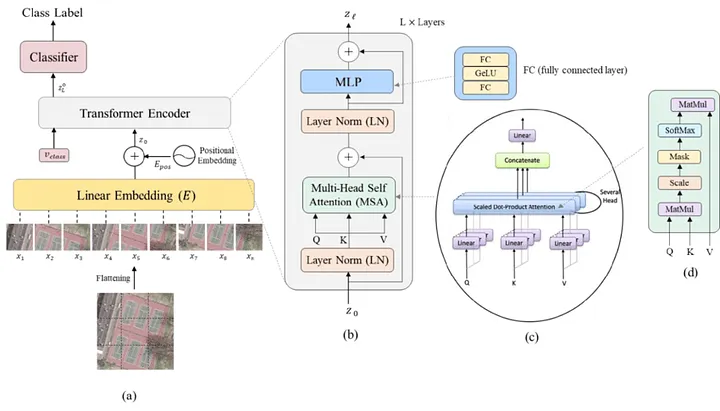

In [4]:
# Carregar a imagem:
imagem = cv2.imread('img.png') # A imagem vem no padrão BGR
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB);imagem_rgb # Imagem em RGB

Como vemos na imagem:

$a.1.$ Seguimenta-se a imagem original em uma sequência de patchs. Note que a ideia aqui é lidar com a imagem como se fosse uma sequência. De fato, uma [*string*](https://developers.google.com/edu/python/strings?hl=pt-br) é uma sequência, um vetor de caracteres. Uma imagem é computacionalmente interpretada como uma matriz, e uma matriz nada mais é do que uma lista de listas, computacionalmente falando.

$a.2.$ Em seguida essas sequências que forma pedaços da imagem são transformadas em *embeddings*, representações vetoriais densas de dados em uma forma numérica que preservam informações semânticas relevantes. A partir daqui caimos na arquitetura transformer tradicional.

$a.3.$ O ***embedding* posicional** é então adicionada a esses vetores (*tokens*). O ***embedding* posicional** permite que a rede saiba onde cada subimagem está posicionada originalmente na imagem. Sem esta informação, a rede não seria capaz de saber onde cada imagem seria colocada, levando a previsões potencialmente erradas! (Exatamente igual para o caso tradicional de Transformer para  NLP).

    Note que aqui, estamos trabalhando apenas com o encoder. Sabemos que
    a arquitetura transformer é composta por duas estruturas fundamentais,
    encoder e decoder. O encoder é responsável pela extração de caracteristicas
    da sequência, ou seja, é a estrutura de classificação.

    A título de estudo, acho importante esse apontamento, porque nem no
    artigo do modelo, nem no texto do material implementativo, é feito
    esse esclarecimento. Entendo que seja óbvio, mas quero deixar aqui
    esse aprofundamento na definição do "modelo transformer" utilizado.
    Não é toda a arquitetura completa, é apenas o encoder, é apenas para
    classificação, o ViT não trata de geração de imagem.

$a.4.$ Esses *tokens* são então passados, juntamente com um *token* de classificação especial (**aprendizado supervisionado**), para os blocos codificadores do transformador, onde cada um é composto por: Uma [***Layer Normalization*** (**LN**)](https://arxiv.org/pdf/1607.06450), seguida por uma [***Multi-head Self Attention*** (**MSA**)](https://paperswithcode.com/method/multi-head-attention) e uma conexão residual. Em seguida, um segundo LN, um [***Multi-Layer Perceptron*** (**MLP**)](https://www.deeplearningbook.org/contents/mlp.html) e novamente uma conexão residual. Esses blocos são conectados consecutivamente.
  
$a.5.$ Por fim, um bloco **MLP** de classificação é utilizado para a classificação final apenas no token de classificação especial, que ao final deste processo possui informações globais sobre a imagem.



A métodologia que utilizada nesses materiais práticos é construir um modelo cru, de modo que o vá complementando a cada implementação nova. Manterei essa didática aqui.

In [5]:
# Pontapé inicial:
class MyViT(nn.Module):
  def __init__(self):
    # Super constructor
    super(MyViT, self).__init__()

  def forward(self, images):
    pass

**Nota - função Super():**

De forma resumida, função **super()** permite que uma subclasse possa utilizar métodos da classe da qual ela foi derivada, sem que precise sobrescrever ou recriar do zero métodos já implementados. É muito comum no contexto de heranças dá dinamismo aos códigos, respeitando inclusive princípios de *Clean Code*.

# 1º Passo: Sequenciamento da Imagem

A **arquitetura transformer**, por padrão, é construida para lidar com entradas 1D, ou seja, vetores, ou tensores de primeira ordem. Imagens são 2D, ou seja, matrizes, ou tensores de segunda ordem. Deste modo, precisamos estabelecer uma estratégia de "sequênciamento da imagem", no sentido de transformar imagens em sequências, ou seja, subdividir matrizes em vetores.

A ideia que o artigo implementa é remodelar a imagem de entrada $x \in \mathbb{R}^{H \times W \times C}$ numa sequência de patchs *achatados* $x_p \in \mathbb{R}^{N \times P^2C}$, onde:

* $(W,H)$, *weight* e *height*, é a resolução original da imagem. (No nosso caso $(28,28)$).
* $C$ é o numero de canais. (No nosso caso, temos apenas $1$ canal de cor).
* $(P,P)$ é a resolução para cada subconjunto da imagem original.
* $N = \frac{HW}{P^2}$ é o numero de subconjuntos de subimagens da imagem, que também serve como o comprimento efetivo da sequência de entrada para o Transformer. É bom guardar essa informação, porque ele de fato será utilizado como entrada na parte do ***Transformer Encoder***

O Transformer usa um tamanho constante de vetor latente $D$ em todas as suas camadas, então *achatamos* as subimagens da imagem original e as mapeamos para dimensões $D$ com uma projeção **linear treinável**.

$$
\textbf{z}_0=[\textbf{x}_{class};\textbf{x}_p^1\textbf{E};...;\textbf{x}_p^N\textbf{E}] + \textbf{E}_{pos}, \ \ \ \textbf{E}\in \mathbb{R}^{(P^2C)\times D},\ \textbf{E}_{pos}\in \mathbb{R}^{(N+1)\times D}
$$

Neste exemplo, remodelando as entradas, que possuem tamanho $\small (N, C, H, W)$, em ou seja, $\small  (N, 1, 28, 28)$, para $\small  (N, \text{#Patches}, \text{Patch dimensionality})$ onde a dimensionalidade de um patch é ajustada de acordo, dividimos cada imagem de dimensão $\small  (1, 28, 28)$ em *patches* (fragmentos) de $7\times7$ (ou seja, cada patch terá o tamanho de 4x4). Assim, obtemos $7\times 7=49$ subimagens a partir de uma única imagem. Portanto, reformatamos a entrada $\small  (N, 1, 28, 28)$ para:

$$(N, P^2, HWC/P^2) = (N, 7\times7, 4\times4) = (N, 49, 16)$$

Observe que, enquanto cada *patch* é uma imagem de tamanho $1\times4\times4$, nós o *achatamos* para um vetor de $16$ dimensões. Além disso, neste caso, tínhamos apenas um canal de cor. Se tivéssemos vários canais de cores, esses também seriam *achatados* no vetor.

In [6]:
# Baixando Imagem:
!curl -o img.png https://miro.medium.com/v2/resize:fit:640/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4832  100  4832    0     0  21090      0 --:--:-- --:--:-- --:--:-- 21192


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
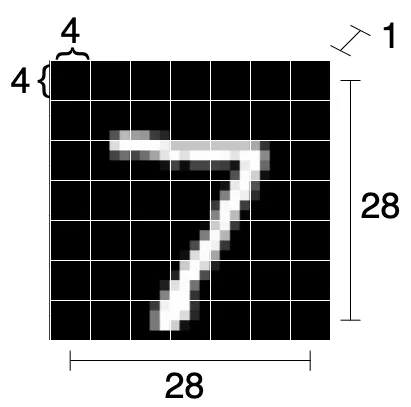

In [7]:
# Carregar a imagem:
imagem = cv2.imread('img.png') # A imagem vem no padrão BGR
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB);imagem_rgb # Imagem em RGB

Definido a estratégia para transformar a imagem 2D em sequências de subconjuntos da imagem, subimagens, 1D, criaremos aqui então uma função que realize essa operação do zero. Note que essa é uma maneira ineficiente de realizar a operação, mas o código é intuitivo para aprender sobre o conceito principal.

In [8]:
# Implementando o "sequenciamento da imagem":
def patchify(images, n_patches):
    n, c, h, w = images.shape # Cada compodente é atribuida a uma variável.

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

**Nota:**

o comando `assert` é um comando de verificação de condição utilizado no ambinto de depuração do código. A ideia é verificar condições que o programador acredita serem sempre verdadeiras durante o desenvolvimento. O `assert` ajuda a capturar bugs e problemas de lógica. A grosso modo, é uma espécie de `if`, verificação condicional, misturado com `try`, manipulação de exceção.

Dito isso, podemos então executar a primeira complementação do modelo. Vamos implementar dentro do modelo, no *forward*, a função de *achatamento* da imagem, ou seja, a função que subdivide a imagem em *patchs*.

Note que há uma verificação para saber se a razão entre as dimensões da imagem é o n_patches é inteira, ou seja, dado a construção do código, é obrigatório que n_patches seja múltiplo das dimensões *weight* e *height* da imagem.

In [9]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Atributos:
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches # int

    # Verificação:
    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches) # Implementação da função de sequênciamento da imagem
    return patches

Agora que temos nossos *patches* achatados, podemos mapear cada um deles através de uma mapeamento **Linear**. Enquanto cada patch era um vetor de $4\times4=16$ dimensões, o mapeamento **linear** pode mapear para qualquer tamanho de vetor arbitrário. Assim, adicionamos um parâmetro ao construtor da nossa classe, chamado `hidden_d` para '*dimensão oculta*'.

Neste exemplo, usaremos uma dimensão oculta de $8$ camadas, mas, em princípio, qualquer número pode ser utilizado aqui. Estaremos, portanto, mapeando cada patch de $16$ dimensões para um patch de $8$ dimensões.

Simplesmente criamos uma camada `nn.Linear` e a chamamos em nossa função forward. O método [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) da subclasse `nn` aplica uma **transformação linear** aos dados recebidos tal que $\small y=xA^T+b$.

In [10]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Atributos
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Mapeamento linear:
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1]) # chw[0] = Canal de Cores:
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)
    return tokens

O construtor da classe agora informa à classe o tamanho das nossas imagens de entrada (número de canais, altura e largura). Observe que, nesta implementação, a variável n_patches é o número de patches que encontraremos tanto na largura quanto na altura (no nosso caso, é $7$ porque dividimos a imagem em patches de $7\times7$).

# 2º Passo: Adicionando o token de classificação

A **arquitetura transformer** apresenta um conceito interessante que utilizaremos aqui. Se quiséssemos realizar outra tarefa *downstream*, só precisaríamos adicionar outro ***token* especial** para a outra tarefa *downstream* e um **classificador** que receba como entrada este novo *token*.

O **v-class** é um ***token* especial** que adicionamos ao nosso modelo e tem o papel de capturar informações sobre os outros tokens. Isso acontecerá com o [Multihead Self-Attention](https://paperswithcode.com/method/multi-head-attention), o **bloco MSA**.

$$\textbf{z}'_{\textit{l}} = \text{MSA}(\text{LN}(\textbf{z}'_{\textit{l}-1}))+\textbf{z}'_{\textit{l}-1}, \ \ \ \ \ \textit{l} = 1...L$$

Quando informações sobre todos os outros tokens estiverem presentes aqui, poderemos classificar a imagem usando apenas este ***token* especial**. O valor inicial do token especial (aquele alimentado ao **encoder** do transformer) é um parâmetro do modelo que precisa ser aprendido.

Para isso, adicionáremos mais um parâmetro no nosso modelo para que o treinamento desse ***token* especial**, de modo que ele será adicionado ao nosso tensor $\small (N,49,8)$ convertendo assim para um tensor de $\small  (N,50,8)$.




In [11]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Atributos:
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Mapeamento linear:
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1]) # chw[0] = Canal de Cores:
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) V-Class - Token de Classificação aprendivel:
    self.class_token = nn.Parameter(torch.rand(1,self.hidden_d)) # Instanciado aleatóriamente:

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adicionando o token de classificação no tensor de tokens:
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
    return tokens

Observe que o token de classificação é colocado como o primeiro token de cada sequência. Isso será importante ter em mente quando formos recuperar o token de classificação para alimentar a [Multi-Layer Perceptrons (MLP)](https://www.deeplearningbook.org/contents/mlp.html) final.

# 3º Passo: Codificicação Posicional

Esse conceito é fundamental para o funcionamento adequado **estrutura transformer**. Sem saber *reconhecer a posição* dos elementos da sequência, o **bloco MSA** fica prejudicado. A codificação posicional permite que o modelo entenda onde cada *patch* seria colocado na imagem original.

O [artigo original](https://arxiv.org/pdf/1706.03762) sugere codificação posicional utilizando funções trigonométricas, por meio de funções $seno$ e $cosseno$, que são funções de periodicidade conhecida. A ideia aqui é seguir essas sugestão, em particular, adicionando valores de alta frequência às primeiras dimensões e valores de baixa frequência às dimensões posteriores.

$$
p_{i,j}=
\begin{cases} \sin\left(\frac{i}{1000^d\frac{j}{emb_{dim}}}\right),\ \text{se}\ j\ \text{for par} \\
\cos\left(\frac{i}{1000^d\frac{j-1}{emb_{dim}}}\right),\ \text{se}\ j\ \text{for impar}
\end{cases}
$$

Esse ***embedding* posicional** é uma função do numero de elementos na sequência e a dimensionalidade de cada elemento. Por isso, é sempre um tensor **bidimensional** ou "retângulo".


Podemos construir uma função simples que, dado o número de tokens e a dimensionalidade de cada um deles, produz uma matriz onde cada coordenada (i, j) é o valor a ser adicionado ao token i na dimensão j.

In [12]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

Podemos então ver uma demonstração gráfica dessa ideia para termos uma noção visual do posicionamento. Pelo *heatmap* plotado, vemos que todas as 'linhas horizontais' são diferentes umas das outras, e assim as amostras podem ser distinguidas.

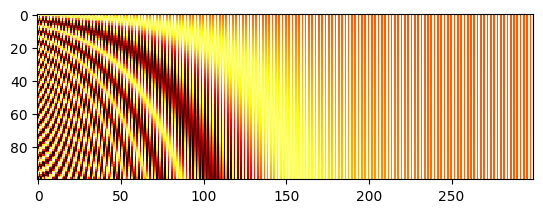

In [13]:
# Biblioteca para visualização:
import matplotlib.pyplot as plt

# Demonstração Gráfica:
plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()


Agora podemos adicionar essa codificação posicional ao nosso modelo após o mapeamento linear e a adição do token de classe.

In [14]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Mapeamento linear:
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) V-Class - Token de Classificação aprendivel:
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Embedding Posicional
    self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    self.pos_embed.requires_grad = False

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(n, 1, 1)
    out = tokens + pos_embed
    return out

Definimos o ***embedding* posicional** como um parâmetro do nosso modelo (que não atualizaremos configurando seu `requires_grad` como `False`). Observe que no método `forward`, como os tokens têm tamanho $\small (N, 50, 8)$, precisamos repetir a matriz de incorporação posicional $\small (50, 8)$ $\small N$ vezes.

# 4º Passo: Trasformer Encoder

Finalmente então chegamos no *transformer*, ou melhor, no bloco ***encoder*** do *transformer*, que é estrutura matemático-argumentativa que utilizaremos para a classificação das imagens. Um bloco ***encoder*** toma como entrada nosso tensor atual $[N, S, D]$, onde:

* $\small N$, como já vimos na parte de *achatamento* da imagem 2D em 1D, é $\small N = HW/P^2$ e aqui, é o utilizada como ***batch size***.

* $\small S$ é a o tamanho da sequência, ***sequence length***.

* $\small D$ é a dimensão dos ***embeddings***.

e produz um tensor de mesma dimensionalidade.


## Bloco Encoder: 1º Parte

A primeira parte do bloco de *encoder* aplica um [***Layer Normalization***](https://paperswithcode.com/method/layer-normalization) nos tokens, então uma [***Multi-head Self Attention***](https://medium.com/@akash.kesrwani99/multi-head-self-attention-short-understanding-e90a34866730) e finalmente adiciona um [***residual connection***](https://arxiv.org/pdf/1512.03385).

**Layer Normalization**

O conceito de ***Layer Normalization*** ou ***LayerNorm*** foi introduzida por [Ba, Kiros e Hinton em 2016](https://arxiv.org/pdf/1607.06450) com o intuito de superar os desvantagens da normalização por lotes, [*batch normalization*](https://arxiv.org/pdf/1502.03167).

A principal motivação para o desenvolvimento dessa técnica é lidar com a mudança na distribuição das ativações durante o treinamento, um problema conhecido como "deslocamento covariante interno".

Mudanças na saída de uma camada tendem a causar mudanças altamente correlacionadas nas entradas somadas do próxima camada, especialmente com unidades `ReLU` cujos resultados podem mudar muito. Isso sugere que o problema de "deslocamento covariante", "*Covariant Shift*", pode ser reduzido ao fixar a média e a variância das entradas somadas dentro da mesma camada. Portanto, computamos as **estatísticas de normalização** por camada sobre todas as **unidades ocultas**, *hidden layers*, na mesma camada, temos:

$$μ^l=\frac{1}{H}\sum_{i=1}^H a_i^l \ \ \ \sigma^l=\sqrt{\frac{1}{H}\sum_{i=1}^H(a_i^l-\mu^l)^2}$$

onde:

* $H$ é o numero de unidades ocultas na camada, ou seja, de forma resumida, note que a ideia é trabalhar com o [$momentum$](https://pt.wikipedia.org/wiki/Momento_(estat%C3%ADstica)) teórico.

De modo que:

$$\textbf{h}^t=f\left[\frac{\textbf{g}}{\sigma^t} \bullet (\textbf{a}^t-\mu^t)+\textbf{b}\right]$$

De forma resumida, é a mesma ideia da padronização de regressoras para o caso de uma, já muito conhecida, [Regressão Linear](https://pt.wikipedia.org/wiki/Regress%C3%A3o_linear), porém a um refinamento para a realidade complexa de *deep learning*.


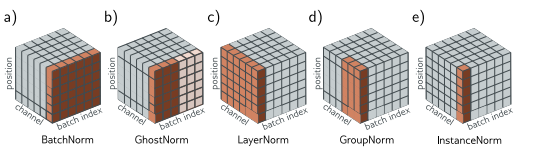

Costuma-se aplicar a normalização de camada, *layer normalization*, a uma entrada de $(N, d)$, onde $d$ é a dimensionalidade. Felizmente, o módulo de normalização de camada também generaliza para múltiplas dimensões. A normalização de camada é aplicada apenas à última dimensão. Podemos, portanto, fazer com que cada uma de nossas matrizes $50\times8$ (representando uma única sequência) tenha média $0$ e padrão $1$. Após passarmos o tensor $(N, 50, 8)$ pelo **LN**, ainda obtemos a mesma dimensionalidade.


**Multi-Head Attention**

O [multi-head attention nasce da ideia de **atenção**. Uma **função de atenção** pode ser descrita como o mapeamento de uma consulta, *query*, e um conjunto de pares chave-valor, *key*-*value*, para uma saída, onde a consulta, *query*, as chaves, *keys*, os valores, *values*, e a saída são todos vetores.

Isso não é uma ideia do artigo [Attention Is All You Need](https://arxiv.org/pdf/1706.03762), já mencionado aqui, mas em tal artigo eles elaboram a ideia do *dot-product self attention* escalonando-o pela $\sqrt{d_k}$, com o argumento empirico de melhoria de desempenho. Deste modo:

$$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Onde:

* $Q$ é o matriz de consulta (*query*);
* $K$ é a matriz de chaves (*keys*);
* $V$ é a matriz de valores (*values*).

Note que há a plicação de uma **função softmax** para obter os pesos sobre os valores. A aplicação da softmax transforma a saída, *logits* até então, numa distribuição de probabilidade.

Em vez de executar uma única **função de atenção** com chaves, valores e consultas de dimensão $d_{model}$, é benéfico projetar **linearmente** as consultas, chaves e valores $h$ vezes com diferentes projeções lineares aprendidas para dimensões $d_k$, $d_k$ e $d_v$, respectivamente. Em cada uma dessas versões projetadas de consultas, chaves e valores, realizamos então a função de atenção em paralelo, produzindo uma atenção multi-cabeças de dimensão $d_v$. A Multi-Head Attention é uma expansão paralelizavel da ideia de **atenção** que permite que o modelo preste atenção **simultaneamente** a informações de diferentes subespaços de representação em diferentes posições. Com uma única cabeça de atenção, a média inibe isso.

$$\text{MultHead}(Q,K,V)=\text{Concat}(\text{head}_1,...,\text{head}_h)W^O$$

Onde:

$$\text{head}_i=\text{Attention}(QW_i^Q,KW_i^K,VW_i^V)$$

Onde as projeções são parametros matriciais $W_i^Q \in \mathbb{R}^{d_{model} \times d_k}$, $W_i^K \in \mathbb{R}^{d_{model} \times d_k}$, $W_i^V \in \mathbb{R}^{d_{model} \times d_v}$. Caso não haja do leitor, familiaridade com os mecanismos de atenção e multi-head, fica a sujestão do [artigo](https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/) legal de [Yasuto Tamura](https://data-science-blog.com/blog/author/yasuto/). Depois que todos os resultados são obtidos, eles são concatenados. Finalmente, o resultado é passado por uma **camada linear** (para garantir).

A ideia intuitiva por trás da atenção é que ela permite modelar a relação entre as entradas. O que faz um '0' ser um zero não são os valores individuais dos pixels, mas como eles se relacionam entre si.

In [15]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

Observe que, para cada *head*, criamos funções de mapeamento $\small Q$, $\small K$ e $\small V$ **distintas** (matrizes quadradas de tamanho $4\times 4$ em nosso exemplo).

Como nossas entradas serão sequências de tamanho $\small (N, 50, 8)$, e usaremos apenas $\small 2$ *heads*, em algum momento teremos um tensor $\small (N, 50, 2, 4)$, use um `nn.Linear(4, 4)` módulo nele e, em seguida, volte, após a concatenação, para um tensor $\small (N, 50, 8)$

Nota:

    Usar loops não é a maneira mais eficiente de calcular o
    self-attention de múltiplas heads, mas torna o código muito
    mais claro para o aprendizado.


**Residual Connections**

O conceito de ***Residual connections*** ou *skip connections* trazem um ar de recursividade de modo que elas são ramificações no caminho computacional, onde a entrada de cada camada da rede $\small f[\bullet]$é adicionada de volta à saída, de modo que:

$$
\begin{align*}
h_1 &= x+f_1[x,\phi_1] \\
h_2 &= h_1+f_2[h_1,\phi_2]\\
h_3 &= h_2+f_3[h_2,\phi_3]\\
y &= h_3+f_4[h_3,\phi_4]
\end{align*}$$

A visão atual é que as conexões residuais, *residual connections*, agregam um valor próprio, além de permitir o treinamento de redes mais profundas. Essa perspectiva é apoiada pelo fato de que as superfícies de perda das redes residuais ao redor de um mínimo tendem a ser mais suaves e mais previsíveis do que as da mesma rede quando as conexões de salto são removidas. Isso pode tornar mais fácil aprender uma boa solução que se generalize bem. Fonte: [Understanding Deep Learning by Simon J.D. Prince](https://udlbook.github.io/udlbook/)

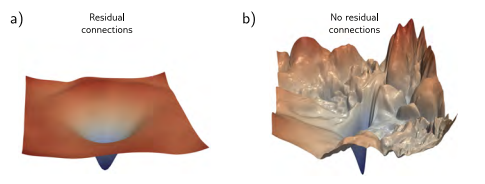

Vamos adicionar uma *residual connection* que adicionará nosso tensor original $\small (N, 50, 8)$ ao tensor $\small (N, 50, 8)$ obtido após **LN** (*Layer Normalization*) e **MSA** (*Multi-Head Self-Attention*).

In [16]:
# Bloco do Encoder:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        return out

Com esse mecanismo de autoatenção, o token da classe, $v_{class}$, (primeiro token de cada uma das N sequências) agora possui informações sobre todos os outros tokens!

Tudo o que resta para o encoder transformer é apenas uma simples conexão residual entre o que já temos e o que obtemos após passar o tensor atual por outra camada de normalização de camada (*Layer Normalization* - **LN**) e uma rede neural de múltiplas camadas (**MLP**). A **MLP** é composta por duas camadas, onde a camada oculta geralmente é quatro vezes maior (este é um parâmetro).

In [17]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [18]:
# Analisando o modelo:
model = MyViTBlock(hidden_d=8, n_heads=2)

x = torch.randn(7, 50, 8)  # Dummy sequences
print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


Agora que o bloco do ***encoder*** está pronto, só precisamos inseri-lo em nosso modelo maior de **Vision Transformer (ViT)**, que é responsável por dividir a imagem em *patches* antes dos blocos transformer e realizar a classificação depois.

Podemos ter um número arbitrário de blocos transformer. Neste exemplo, para simplificar, usarei apenas $\small 2$. Também adicionamos um parâmetro para saber quantas cabeças cada bloco do codificador usará.

In [19]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out

Mais uma vez, se executarmos um tensor aleatório de dimensão $\small (7, 1, 28, 28)$ através do nosso modelo, ainda obteremos um tensor de dimensão $\small (7, 50, 8)$.

# 5º Passo: Multi-Layer Perceptron (MLP)

Finalmente, podemos extrair apenas o token de classificação (primeiro *token*) de nossas $\small N$ sequências e usar cada token para obter $\small N$ classificações.

Como decidimos que cada *token* é um vetor dimensional de $\small 8$, e como temos 10 dígitos possíveis, podemos implementar a MLP de classificação como uma matriz simples de 8x10, ativada com a função SoftMax.


In [20]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

In [22]:
if __name__ == "__main__":
    main()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11757354.76it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 355770.82it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3165403.82it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6061256.37it/s]


Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Usando dispositivo:  cpu 


Trainning:  20%|██        | 1/5 [03:59<15:58, 239.61s/it]

Época 1/5, loss: 2.06



Trainning:  40%|████      | 2/5 [07:56<11:54, 238.18s/it]

Época 2/5, loss: 1.87



Trainning:  60%|██████    | 3/5 [11:55<07:56, 238.23s/it]

Época 3/5, loss: 1.79



Trainning:  80%|████████  | 4/5 [16:07<04:03, 243.85s/it]

Época 4/5, loss: 1.77



Trainning: 100%|██████████| 5/5 [20:03<00:00, 240.64s/it]


Época 5/5, loss: 1.75


Teste: 100%|██████████| 79/79 [00:20<00:00,  3.90it/s]

Test loss: 1.74
Teste de Acuracia (simples): 0.12


In [23]:
model

MyViT(
  (linear_mapper): Linear(in_features=16, out_features=8, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x MyViTBlock(
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mhsa): MyMSA(
        (q_mappings): ModuleList(
          (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
        )
        (k_mappings): ModuleList(
          (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
        )
        (v_mappings): ModuleList(
          (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
        )
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=8, out_features=32, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=32, out_features=8, bias=True)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

# Predições:

In [24]:
# Baixando imagem:
!curl -o img.jpeg https://a-static.mlcdn.com.br/450x450/numero-3-em-acm-preto-125mm-600-3-numeral/copafer/2327863-2327877/75601d9a86c7056c2210eda4d2aca3dc.jpeg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7880  100  7880    0     0   9812      0 --:--:-- --:--:-- --:--:--  9813


In [25]:
import cv2

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
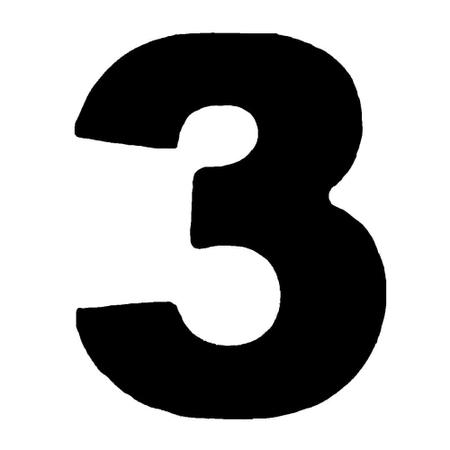

In [26]:
# Carregar a imagem:
imagem = cv2.imread('img.jpeg', cv2.IMREAD_GRAYSCALE);imagem

In [27]:
# Redimensionar para 28x28 pixels

imagem_redimensionada = cv2.resize(imagem, (28, 28))
#imagem_normalizada = imagem_redimensionada / np.max(imagem_redimensionada) # Opcional, mas geralmente útil
#entrada = torch.tensor(imagem_redimensionada, dtype=torch.float32).to(device);entrada

In [28]:
# Garantir que o modelo está no dispositivo correto:
model.to(device)
saida = model.forward(x).to(device)

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
x.shape

In [ ]:
classe_predita = torch.argmax(saida);classe_predita

In [ ]:
x

In [ ]:
transform = ToTensor()
train_set = MNIST(root='./../datasets',train=True, download=True,transform=transform)
train_loader = DataLoader(train_set, shuffle=True, batch_size=128)

In [ ]:
for batch in train_loader:
  x,y = batch
  print(f'variáveis -> {x.shape}, Resposta -> {y.shape}')

In [ ]:
x,y = batch

In [ ]:
x.to(device)

In [ ]:
x.shape